In [1]:
pip install qutip

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from qutip import *
import numpy as np
import math
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
import matplotlib
import numpy.linalg as la
import itertools
from tqdm import tqdm
from scipy.linalg import block_diag
from scipy.optimize import root
from scipy.optimize import minimize
from IPython.display import display
from tqdm.notebook import tnrange
import warnings
warnings.filterwarnings('ignore')

In [3]:
def ham_energies(N):
    energies = []
    for i in range(N+1):
        energies+=([i]*math.comb(N, i))
    return energies

##################################################################################


def free_ham(N):
    ham0 = fock_dm(2,1)
    free_ham = 0
    for i in range(N):
        ham = [qeye(2)]*N
        ham[i] = ham0
        free_ham += tensor(ham)
    
    return free_ham

##################################################################################


def int_ham(N):
    int_ham = 0
    for i in range(N):
        ham = [qeye(2)]*N
        if i==N-1:
            ham[i] = sigmax()
            ham[0] = sigmax()
        else:
            ham[i] = sigmax()
            ham[i+1] = sigmax()

        int_ham += tensor(ham)
    
    return int_ham

##################################################################################


def spin_ham(N, J):
    return free_ham(N)+J*int_ham(N)

##################################################################################


def min_energy(state):
    N = len(state.dims[0])
    eigenvalues, eigenstates = state.eigenstates()
    sorted_eigen = sorted(eigenvalues, reverse=True)
    energies = ham_energies(N)
        
    return np.dot(sorted_eigen, energies)

##################################################################################


def ergotropy(state):
    N = len(state.dims[0])
    return (state*free_ham(N)).tr()-min_energy(state)

##################################################################################


def energy(state):
    N = len(state.dims[0])
    return (state*free_ham(N)).tr()


##################################################################################

import itertools
from qutip import *

# Assuming `energy(state)` function is already defined

def calc_mean_energy(state, N, k):
    """
    Calculate the mean energy over all possible k-qubit bipartitions of the N-qubit system.
    
    Parameters:
    - state: The N-qubit density matrix.
    - N: The total number of qubits.
    - k: The number of qubits in each bipartition.
    
    Returns:
    - The average energy over all bipartitions.
    """
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    total_energy = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        total_energy += energy(marginal_state)
    
    return total_energy / len(combinations)


##################################################################################
 
def free_energy(state,T):
    N = len(state.dims[0])
    return (state*free_ham(N)).tr()- T*entropy_vn(state)


##################################################################################


def calc_mean_ergotropy(state, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    erg = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        erg += ergotropy(marginal_state)
    
    return erg/len(combinations)



##################################################################################

def calc_mean_entropy(state, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    ent = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        ent += entropy_vn(marginal_state)
    
    return ent/len(combinations)

##################################################################################



def dist_ergotropy(state, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    erg = []
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        erg.append(ergotropy(marginal_state))
    
    return erg

##################################################################################


def random_vector(dim):
    vector = []
    norm = 0 
    for i in range(dim):
        c = np.random.rand() + 1j * np.random.rand()
        norm += abs(c)**2
        vector.append(c)
    return np.array(vector)/np.sqrt(norm)

##################################################################################


def random_product_state(N):
    state = []
    for i in range(N):
        state.append(Qobj(random_vector(2)))
        
    return(tensor(state))


##################################################################################

def random_total_state(N):
    state = Qobj(random_vector(2**N))
    state.dims = [[2]*N, [1]*N]
    return state

##################################################################################


def calc_temp(state):
    p1 = state.diag()[1]
    p0 = state.diag()[0]
    
    return 1/np.log(p0/p1)

##################################################################################


def calc_temp1(state_dm):
    """
    Calculate the temperature based on the diagonal elements of a density matrix.
    """
    diag_elements = state_dm.diag()  # Get the diagonal elements of the density matrix
    
    if len(diag_elements) < 2:
        raise ValueError("Density matrix must have at least two diagonal elements.")
    
    p1 = diag_elements[1]
    p0 = diag_elements[0]
    
    if p0 == 0 or p1 == 0:
        raise ValueError("Diagonal elements cannot be zero for temperature calculation.")
    
    return 1 / np.log(p0 / p1)


##################################################################################


def calc_mean_temp(state, N):
    
    sum_temp = 0
    for i in range(N):
        partial_state = state.ptrace(i)
        sum_temp += calc_temp(partial_state)
        
    return sum_temp/N

##################################################################################


def calc_mean_free_energy(state, T, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    sum_free_energy = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        sum_free_energy += free_energy(marginal_state,T)
    
    return sum_free_energy/len(combinations)

##################################################################################


def calc_mean_min_energy(state, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    sum_min_energy = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        sum_min_energy += min_energy(marginal_state)
        
    return sum_min_energy/len(combinations)

##################################################################################


def calc_mean_energy(state, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    sum_energy = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        sum_energy += energy(marginal_state)
    
    return sum_energy/len(combinations)

##################################################################################


def calc_mean_entropy(state, N, k):
    numbers = [i for i in range(N)]
    combinations = list(itertools.combinations(numbers, k))

    sum_entropy = 0
    for comb in combinations:
        marginal_state = state.ptrace(comb)
        sum_entropy += entropy_vn(marginal_state)
    
    return sum_entropy/len(combinations)

##################################################################################


def calc_partition(T, k):
    partition = 0
    for energy in ham_energies(k):
        partition += np.exp(-energy/T)
    return partition

##################################################################################


def calc_gibbs(T, k):
    H = free_ham(k)
    state = Qobj(-H/T).expm()
    return state/state.tr()

##################################################################################


def g(T,entropy, k):
        return T*(entropy - np.log(calc_partition(T,k)))

##################################################################################


def find_temp(entropy, k, x0 = 1, bounds = [(10**(-5), 1)]):
    result = minimize(g, x0, args=(entropy, k), bounds=bounds)
    return result.x[0]

##################################################################################


def calc_mean_non_eq_free_energy(state, N, k):
    mean_entropy = calc_mean_entropy(state, N, k)
    T = find_temp(mean_entropy, k)
    return calc_mean_energy(state, N, k) - T*mean_entropy + T*np.log(calc_partition(T, k))


def calc_mean_non_eq_free_energy1(state, N, k, T):
    mean_entropy = calc_mean_entropy(state, N, k)
    return calc_mean_energy(state, N, k) - T*mean_entropy 


In [4]:
def random_vector(dim):
    vector = []
    norm = 0 
    for i in range(dim):
        c = np.random.rand() + 1j * np.random.rand()
        norm += abs(c)**2
        vector.append(c)
    return np.array(vector)/np.sqrt(norm)

def random_total_state(N):
    state = Qobj(random_vector(2**N))
    state.dims = [[2]*N, [1]*N]
    return state



Case of $\beta=\sum_{i<j}\beta_{ij}$

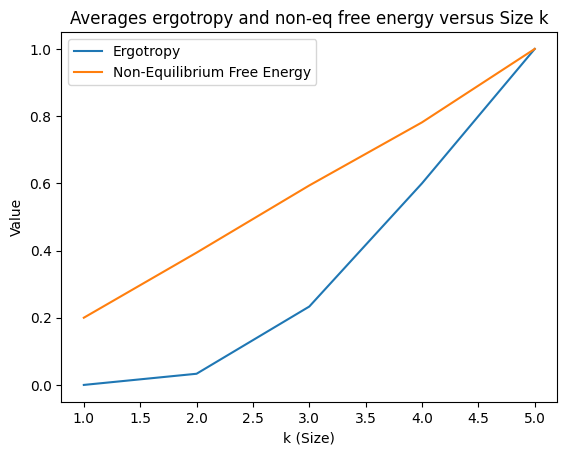

In [5]:
N = 5  # Total number of qubits
points = 100
tfinal = 200
state = [fock(2, 0)]*N
state[0] = fock(2, 1)
initial_state = tensor(state)

H = spin_ham(N, 0.01)

tlist = np.linspace(0, tfinal, points)
result = mesolve(H, initial_state, tlist, [])
state3 = result.states[int(3*points/4)]  # Choose a specific time point

# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = state3.proj()

# Lists to store R3 and F3 values for each k
R3_values = []
F3_values = []

# Loop over values of k from 1 to N
for k in range(1, N + 1):
    E1 = 0
    temp = 0
    
    qubits = list(range(N))
    bipartitions = list(itertools.combinations(qubits, k))

    # Calculate temperature for the bipartitions
    for bipartition in bipartitions:
        marginal_state = d1.ptrace(bipartition)
        entropy_value = entropy_vn(marginal_state)  # Entropy for each bipartite state
        temp +=len(bipartitions)/find_temp(entropy_value, k, x0=1, bounds=[(10**(-5), 1)])
    
    temp1 = 1/temp  # Final temperature for this k

    # Calculate energy for each bipartition's Gibbs state
   # for bipartition in bipartitions:
   #     marginal_state = d1.ptrace(bipartition)
   #     gibbs_state = calc_gibbs(temp1, k)
   #     energy_value = energy(gibbs_state)/len(bipartitions)
   #     E1 += energy_value
    
    # Calculate entropy, free energy, and ergotropy for this k
    Ent1 = calc_mean_entropy(d1, N, k)
    F3 = calc_mean_non_eq_free_energy1(d1, N, k, temp1)
    R3 = calc_mean_ergotropy(d1, N, k)

    # Append results to lists
    R3_values.append(R3)
    F3_values.append(F3)

# Plot the values of R3 and F3 versus k
import matplotlib.pyplot as plt

k_values = range(1, N + 1)

plt.plot(k_values, R3_values, label='Ergotropy')
plt.plot(k_values, F3_values, label='Non-Equilibrium Free Energy')
plt.xlabel('k (Size)')
plt.ylabel('Value')
plt.title('Averages ergotropy and non-eq free energy versus Size k')
plt.legend()
plt.show()


Case $\text{S}(\tau_{ij})=\text{S}(\rho_{ij})$

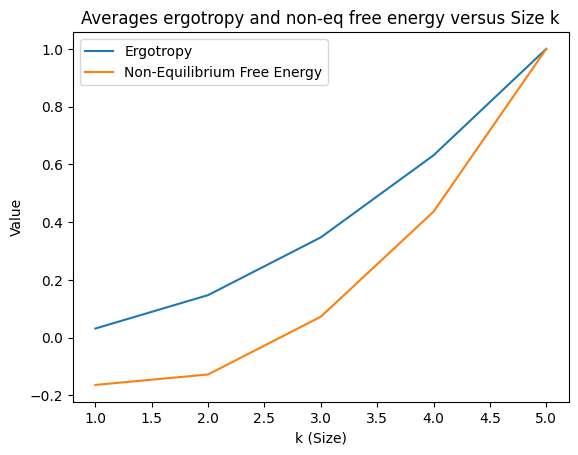

In [6]:
N = 5 # Total number of qubits
points = 100
tfinal = 200
state = [fock(2, 0)]*N
state[0] = fock(2, 1)
initial_state = tensor(state)

H = spin_ham(N, 0.01)

tlist = np.linspace(0, tfinal, points)
result = mesolve(H, initial_state, tlist, [])
state1 = result.states[int(points/4)] 
state3 = result.states[int(3*points/4)]  # Choose a specific time point

# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = state1.proj()

# Lists to store R3 and F3 values for each k
R1_values = []
F1_values = []

# Loop over values of k from 1 to N
for k in range(1, N + 1):
    E1 = 0
    
    qubits = list(range(N))
    bipartitions = list(itertools.combinations(qubits, k))

    # Calculate temperature for the bipartitions
    for bipartition in bipartitions:
        marginal_state = d1.ptrace(bipartition)
        entropy_value = entropy_vn(marginal_state)  # Entropy for each bipartite state
        temp =find_temp(entropy_value, k, x0=1, bounds=[(10**(-5), 1)])
        F1 = calc_mean_non_eq_free_energy1(d1, N, k,temp)
    


    # Calculate energy for each bipartition's Gibbs state
    for bipartition in bipartitions:
        marginal_state = d1.ptrace(bipartition)
        gibbs_state = calc_gibbs(temp1, k)
        energy_value = energy(gibbs_state)/len(bipartitions)
        E1 += energy_value
    
    # Calculate entropy, free energy, and ergotropy for this k
    Ent1 = calc_mean_entropy(d1, N, k)
   
    R1 = calc_mean_ergotropy(d1, N, k)

    # Append results to lists
    R1_values.append(R1)
    F1_values.append(F1)

# Plot the values of R3 and F3 versus k
import matplotlib.pyplot as plt

k_values = range(1, N + 1)

plt.plot(k_values, R1_values, label='Ergotropy')
plt.plot(k_values, F1_values, label='Non-Equilibrium Free Energy')
plt.xlabel('k (Size)')
plt.ylabel('Value')
plt.title('Averages ergotropy and non-eq free energy versus Size k')
plt.legend()
plt.show()


Case $\langle S_{ij}\rangle = S(\tau_{ij})$ 

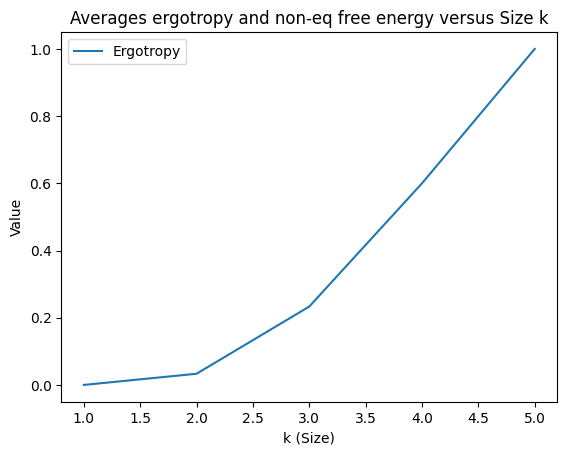

In [7]:
N = 5  # Total number of qubits
points = 100
tfinal = 200
state = [fock(2, 0)]*N
state[0] = fock(2, 1)
initial_state = tensor(state)

H = spin_ham(N, 0.01)

tlist = np.linspace(0, tfinal, points)
result = mesolve(H, initial_state, tlist, [])
state1 = result.states[int(points/4)]
state2 = result.states[int(2*points/4)]
state3 = result.states[int(3*points/4)]  # Choose a specific time point

# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = state3.proj()

# Lists to store R3 and F3 values for each k
R2_values = []
F2_values = []

# Loop over values of k from 1 to N
for k in range(1, N + 1):
    E1 = 0
    temp = 0
    
    qubits = list(range(N))
    bipartitions = list(itertools.combinations(qubits, k))

    # Calculate temperature for the bipartitions
    for bipartition in bipartitions:
        marginal_state = d1.ptrace(bipartition)
        entropy_value = entropy_vn(marginal_state)  # Entropy for each bipartite state
        
    temp +=len(bipartitions)/find_temp(entropy_value, k, x0=1, bounds=[(10**(-5), 1)])
        
        
    F2 = calc_mean_non_eq_free_energy1(d1, N, k, temp)
        
        
    R2 = calc_mean_ergotropy(d1, N, k)

    # Append results to lists
    R2_values.append(R2)
    F2_values.append(F2)

# Plot the values of R3 and F3 versus k
import matplotlib.pyplot as plt

k_values = range(1, N + 1)

plt.plot(k_values, R2_values, label='Ergotropy')
#plt.plot(k_values, F2_values, label='Non-Equilibrium Free Energy')
plt.xlabel('k (Size)')
plt.ylabel('Value')
plt.title('Averages ergotropy and non-eq free energy versus Size k')
plt.legend()
plt.show()


In [8]:
N = 10 # Total number of qubits
k = 2   # Bipartition size (e.g., 2-qubit bipartitions)
E1 = 0
s1=random_product_state(N)
#d1=density_matrix(s1)

state = [fock(2, 0)] * N  # All qubits initially in the ground state
state[0] = fock(2, 1)     # Set the first qubit in the excited state

# Tensor product of all qubit states to form a 12-qubit state
initial_state = tensor(state)

# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = initial_state.proj()
#g1=calc_gibbs(T, k)


qubits = list(range(N))
bipartitions = list(itertools.combinations(qubits, k))

# Calculate energy for each bipartition's Gibbs state
for bipartition in bipartitions:
    # Gibbs state for the bipartition
    marginal_state = d1.ptrace(bipartition)
    entropy_value = entropy_vn(marginal_state)  # Entropy for each bipartite Gibbs state
    #tempa = g(T, entropy_value, k)
    temp= find_temp(entropy_value, k, x0 = 1, bounds = [(10**(-5), 1)])
    gibbs_state = calc_gibbs(temp, k)
    # Calculate the energy for the bipartite Gibbs state
    energy_value = energy(gibbs_state)/len(bipartitions)
    
    # Add the energy of this bipartition to the total energy
    E1 += energy_value
E1



Ent1=calc_mean_entropy(d1, N, k)
mean_energy = calc_mean_energy(d1, N, k)
T= find_temp(Ent1, k, x0 = 1, bounds = [(10**(-5), 1)])

F2=calc_mean_non_eq_free_energy(d1, N, k)
R2=calc_mean_ergotropy(d1, N, k)

#T*Ent1<=E1
np.abs(R2)<=np.abs(F2)


True

Average ergotropy for 8-partite product state

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
[8.673617379884035e-18, 2.0152405538231437e-05, 0.017358736703652494, 0.07841784073549624, 0.2675476143946625, 0.5003414890905067, 0.7504490067538037, 1.0005986756718388]


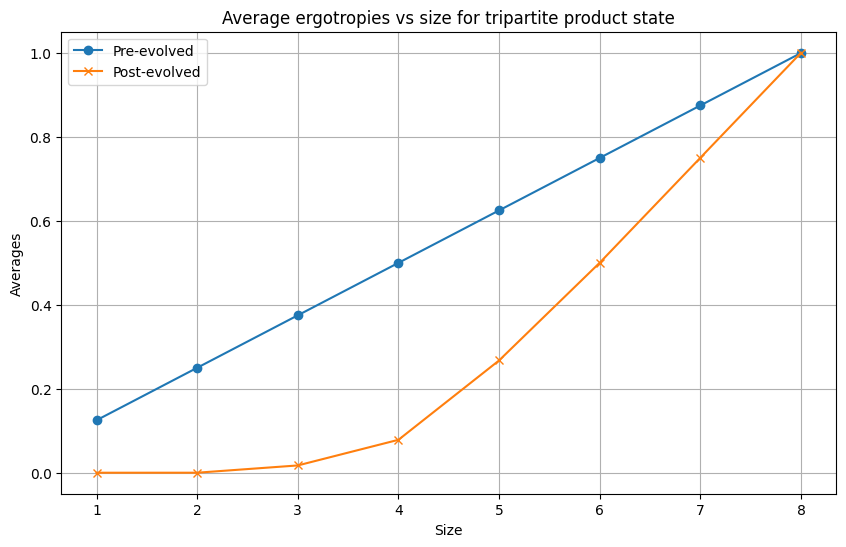

In [9]:
N = 8  # Total number of qubits
points = 100
tfinal = 200
R1_list = []
R2_list = []

#initial_state = random_total_state(N)
H = spin_ham(N, 0.01)


# Step 1: Generate random single-qubit states and form the tensor product for a five-qubit system
# GHZ state for 5 qubits
producta=0
product0=basis(2, 1)
for i in range(N):
    producta=[basis(2,0)]*N
    producta[0]=product0

product = tensor(producta)

tlist = np.linspace(0,tfinal,points)
result = mesolve(H, product, tlist, [])
state0 = product
state1 = result.states[int(points/4)]
state2 = result.states[int(points/2)]
state3 = result.states[int(3*points/4)]
state4 = result.states[-1]
rand_state = random_total_state(N)


# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = product.proj()
d2 = state3.proj()
# Iterate over different bipartition sizes (k) from 1 to N
for k in tqdm(range(1, N+1)):
    R1 = calc_mean_ergotropy(d1, N, k)
    R2 = calc_mean_ergotropy(d2, N, k)
    
    # Store the results for this k
    R1_list.append(np.abs(R1))
    R2_list.append(np.abs(R2))
    
    
print(R1_list)
print(R2_list)

# Plot R2 and F2 vs k

k_values = list(range(1, N+1))
plt.figure(figsize=(10, 6))
plt.plot(k_values, R1_list, label="Pre-evolved", marker='o')
plt.plot(k_values, R2_list, label="Post-evolved", marker='x')
plt.xlabel("Size")
plt.ylabel("Averages")
plt.title("Average ergotropies vs size for tripartite product state")
plt.legend()
plt.grid(True)
plt.savefig('erg1.png')
plt.show()

Average ergotropy for (5,6,7,8,9,10)-partite product state

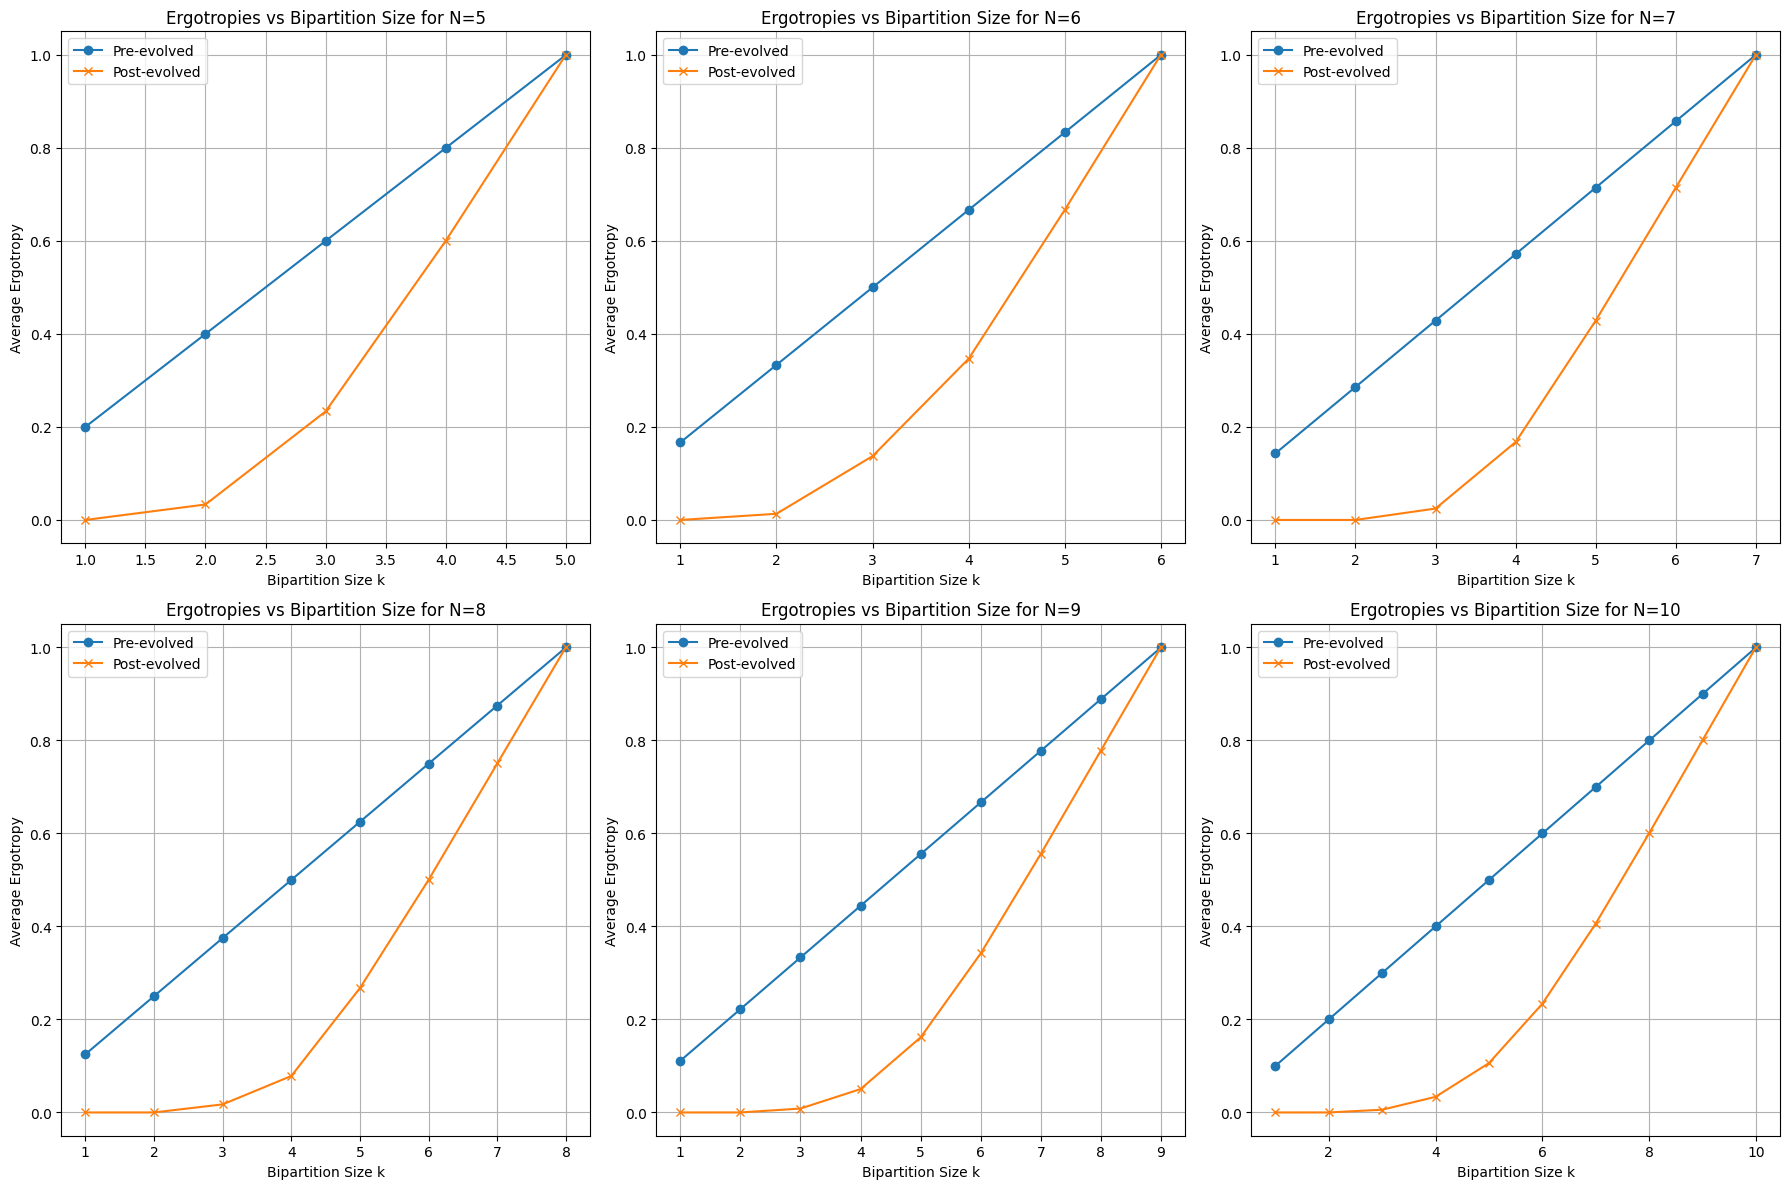

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, mesolve
from tqdm import tqdm

# Define your custom functions `spin_ham`, `random_total_state`, and `calc_mean_ergotropy`
# ...

# Parameters
points = 100
tfinal = 200

# Set up the figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns for N = 5 to 10
axes = axes.flatten()  # Flatten to easily iterate over

# Loop over N from 5 to 10
for idx, N in enumerate(range(5, 11)):
    # Initialize lists to store results
    R1_list = []
    R2_list = []

    # Generate Hamiltonian and initial product state
    H = spin_ham(N, 0.01)
    producta = [basis(2, 0)] * N
    producta[0] = basis(2, 1)
    product = tensor(producta)

    # Time evolution
    tlist = np.linspace(0, tfinal, points)
    result = mesolve(H, product, tlist, [])

    # Define initial and post-evolved states
    d1 = product.proj()  # Initial state density matrix
    d2 = result.states[int(3 * points / 4)].proj()  # Density matrix at t = 3/4 * tfinal

    # Calculate ergotropy for different bipartition sizes k
    for k in range(1, N + 1):
        R1 = calc_mean_ergotropy(d1, N, k)
        R2 = calc_mean_ergotropy(d2, N, k)
        R1_list.append(np.abs(R1))
        R2_list.append(np.abs(R2))

    # Plot results for this N
    k_values = list(range(1, N + 1))
    ax = axes[idx]
    ax.plot(k_values, R1_list, label="Pre-evolved", marker='o')
    ax.plot(k_values, R2_list, label="Post-evolved", marker='x')
    ax.set_xlabel("Bipartition Size k")
    ax.set_ylabel("Average Ergotropy")
    ax.set_title(f"Ergotropies vs Bipartition Size for N={N}")
    ax.legend()
    ax.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('ergotropy_comparison.png')
plt.show()


Average ergotropy for 8-partite random product states

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


[0.4133738310936615, 0.8267476621873229, 1.2401214932809843, 1.6534953243746462, 2.066869155468308, 2.4802429865619717, 2.89361681765564, 3.3069906487493284]
[0.10729731787437634, 0.30386599759015087, 0.6061791444089956, 1.0177447163237314, 1.5226008774787492, 2.0409135030559113, 2.60738810337102, 3.3334543806622037]


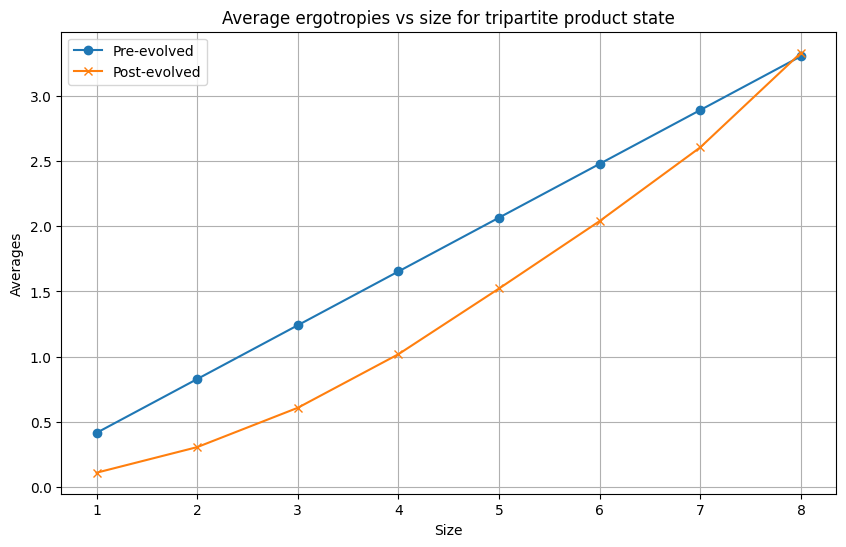

In [11]:
N = 8  # Total number of qubits
points = 100
tfinal = 200
R1_list2 = []
R2_list2 = []

#initial_state = random_total_state(N)
H = spin_ham(N, 0.01)


producta=random_product_state(N)

product = tensor(producta)

tlist = np.linspace(0,tfinal,points)
result = mesolve(H, product, tlist, [])
state0 = product
state1 = result.states[int(points/4)]
state2 = result.states[int(points/2)]
state3 = result.states[int(3*points/4)]
state4 = result.states[-1]
rand_state = random_total_state(N)


# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = product.proj()
d2 = state3.proj()
# Iterate over different bipartition sizes (k) from 1 to N
for k in tqdm(range(1, N+1)):
    R1 = calc_mean_ergotropy(d1, N, k)
    R2 = calc_mean_ergotropy(d2, N, k)
    
    # Store the results for this k
    R1_list2.append(np.abs(R1))
    R2_list2.append(np.abs(R2))
    
    
print(R1_list2)
print(R2_list2)

# Plot R2 and F2 vs k

k_values = list(range(1, N+1))
plt.figure(figsize=(10, 6))
plt.plot(k_values, R1_list2, label="Pre-evolved", marker='o')
plt.plot(k_values, R2_list2, label="Post-evolved", marker='x')
plt.xlabel("Size")
plt.ylabel("Averages")
plt.title("Average ergotropies vs size for tripartite product state")
plt.legend()
plt.grid(True)
plt.savefig('erg_random1.png')
plt.show()

Average ergotropy for (5,6,7,8,9,10)-partite random product state

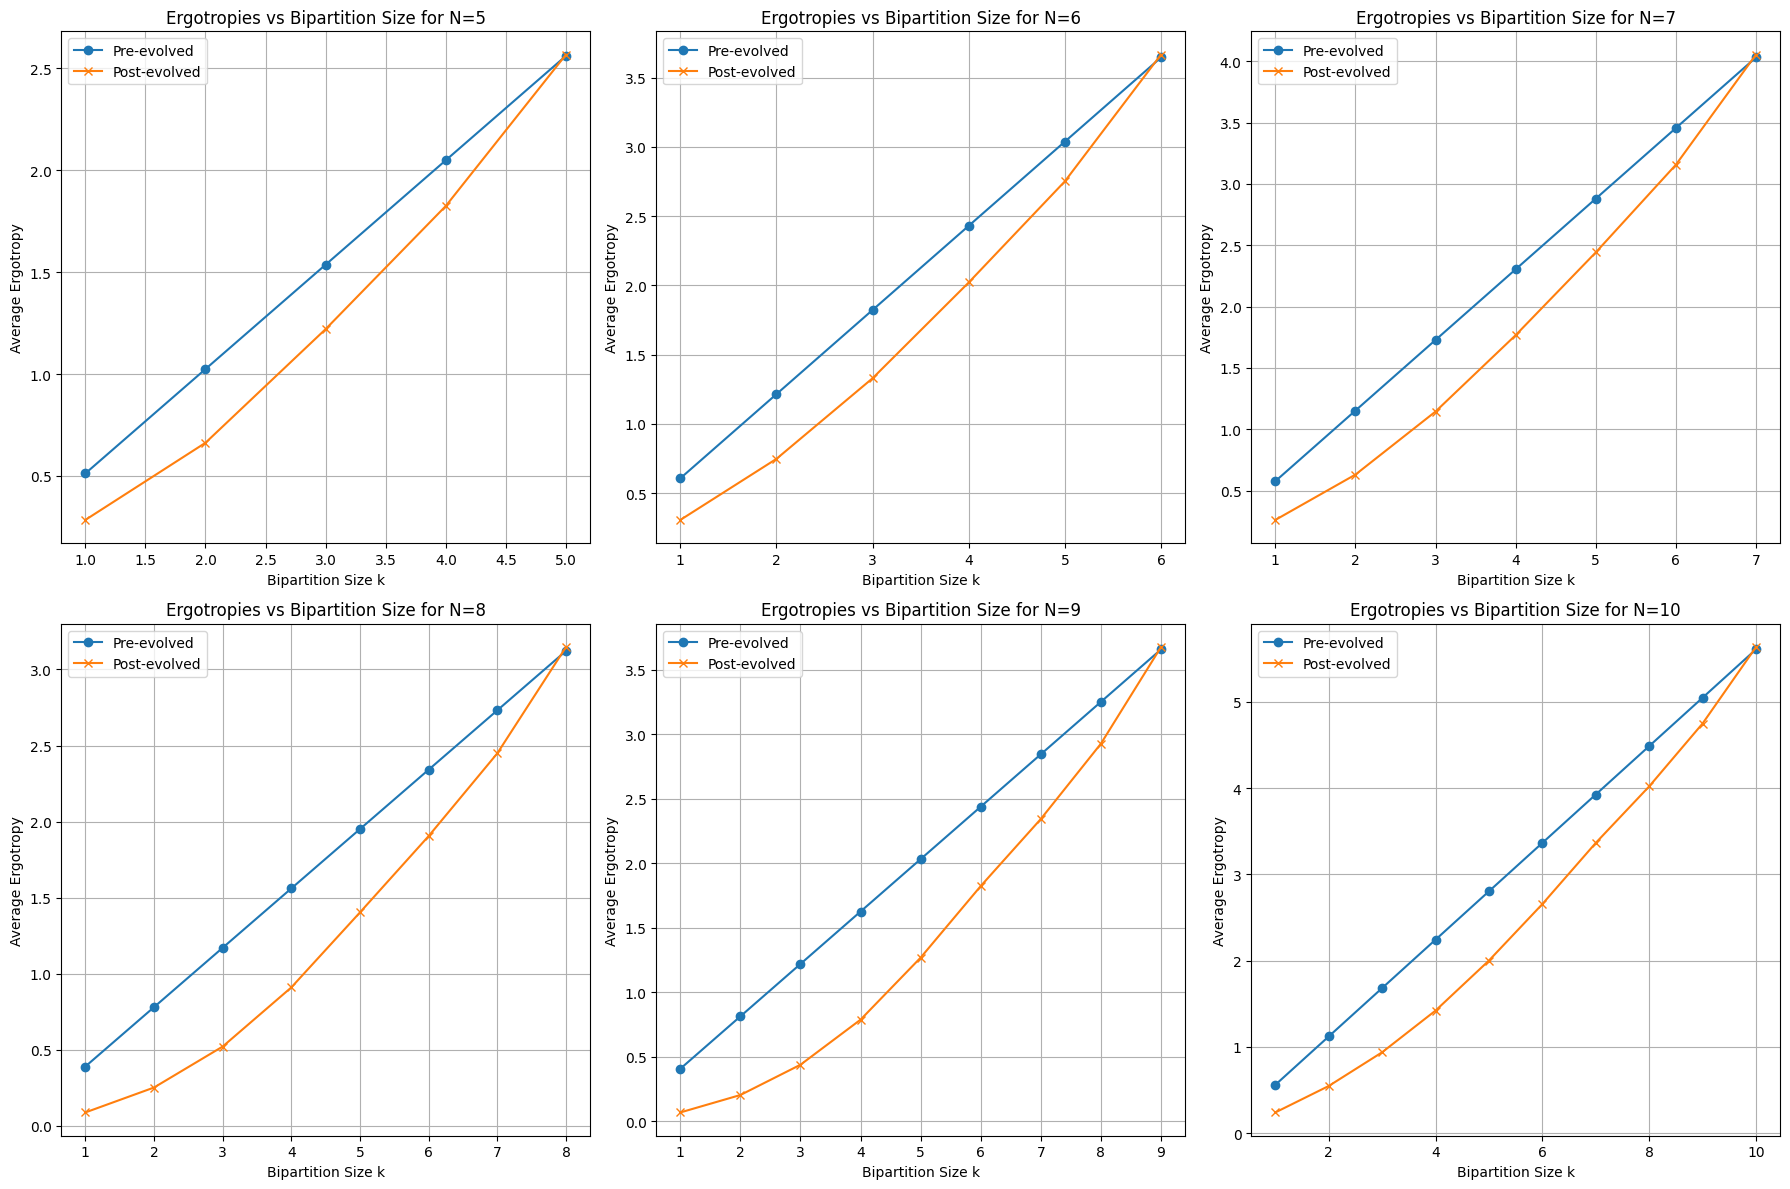

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, mesolve
from tqdm import tqdm

# Define your custom functions `spin_ham`, `random_total_state`, and `calc_mean_ergotropy`
# ...

# Parameters
points = 100
tfinal = 200

# Set up the figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns for N = 5 to 10
axes = axes.flatten()  # Flatten to easily iterate over

# Loop over N from 5 to 10
for idx, N in enumerate(range(5, 11)):
    # Initialize lists to store results
    R1_list3 = []
    R2_list3 = []

    # Generate Hamiltonian and initial product state
    H = spin_ham(N, 0.01)
    producta = random_product_state(N)
    product = tensor(producta)

    # Time evolution
    tlist = np.linspace(0, tfinal, points)
    result = mesolve(H, product, tlist, [])

    # Define initial and post-evolved states
    d1 = product.proj()  # Initial state density matrix
    d2 = result.states[int(3 * points / 4)].proj()  # Density matrix at t = 3/4 * tfinal

    # Calculate ergotropy for different bipartition sizes k
    for k in range(1, N + 1):
        R1 = calc_mean_ergotropy(d1, N, k)
        R2 = calc_mean_ergotropy(d2, N, k)
        R1_list3.append(np.abs(R1))
        R2_list3.append(np.abs(R2))

    # Plot results for this N
    k_values = list(range(1, N + 1))
    ax = axes[idx]
    ax.plot(k_values, R1_list3, label="Pre-evolved", marker='o')
    ax.plot(k_values, R2_list3, label="Post-evolved", marker='x')
    ax.set_xlabel("Bipartition Size k")
    ax.set_ylabel("Average Ergotropy")
    ax.set_title(f"Ergotropies vs Bipartition Size for N={N}")
    ax.legend()
    ax.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('ergotropy_Random2.png')
plt.show()


Case of GHZ state

100%|██████████| 3/3 [00:00<00:00, 70.15it/s]


[0.0, 0.3333333333333331, 1.0]
[0.0, 0.34173275060469255, 1.0251982518140803]


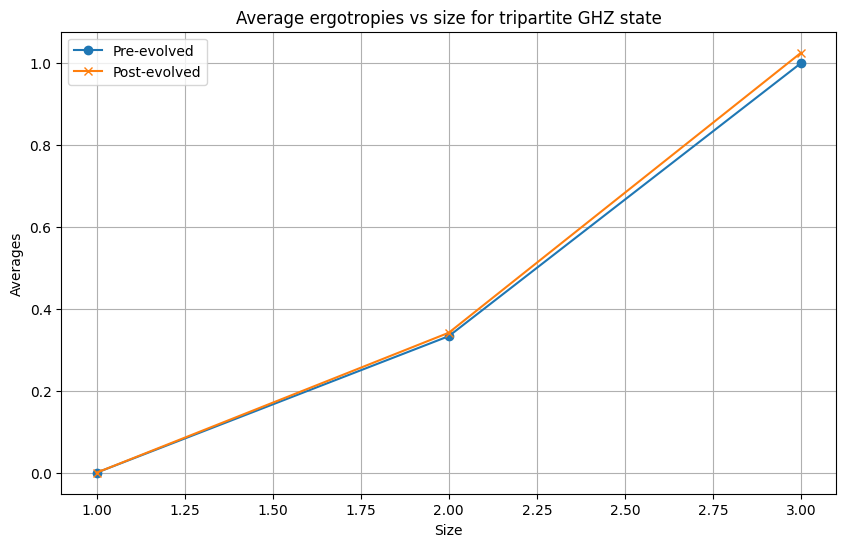

In [13]:
N = 3 # Total number of qubits
points = 100
tfinal = 200
R1_list1 = []
R2_list1 = []

#initial_state = random_total_state(N)
H = spin_ham(N, 0.1)


# Step 1: Generate random single-qubit states and form the tensor product for a five-qubit system
# GHZ state for 5 qubits
ghz=(tensor(basis(2,1), basis(2,0), basis(2,0)) + tensor(basis(2,0), basis(2,1), basis(2,0))+tensor( basis(2,0), basis(2,0), basis(2,1))).unit()

tlist = np.linspace(0,tfinal,points)
result = mesolve(H, ghz, tlist, [])
state0 = product
state1 = result.states[int(points/4)]
state2 = result.states[int(points/2)]
state3 = result.states[int(3*points/4)]
state4 = result.states[-1]



# Create the density matrix (ρ = |ψ⟩⟨ψ|)
d1 = ghz.proj()
d2 = state3.proj()
# Iterate over different bipartition sizes (k) from 1 to N
for k in tqdm(range(1, N+1)):
    R11 = calc_mean_ergotropy(d1, N, k)
    R21 = calc_mean_ergotropy(d2, N, k)
    
    # Store the results for this k
    R1_list1.append(np.abs(R11))
    R2_list1.append(np.abs(R21))
    
    
print(R1_list1)
print(R2_list1)

# Plot R2 and F2 vs k

k_values = list(range(1, N+1))
plt.figure(figsize=(10, 6))
plt.plot(k_values, R1_list1, label="Pre-evolved", marker='o')
plt.plot(k_values, R2_list1, label="Post-evolved", marker='x')
plt.xlabel("Size")
plt.ylabel("Averages")
plt.title("Average ergotropies vs size for tripartite GHZ state")
plt.legend()
plt.grid(True)
plt.savefig('ergotropy_GHZ.png')
plt.show()

100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


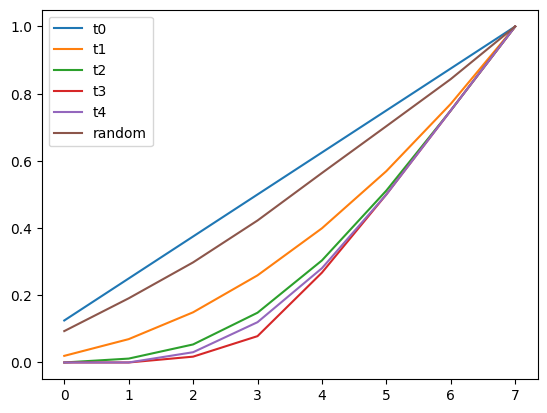

In [14]:
N = 8
points = 100
tfinal = 200

state = [fock(2,0)]*N
state[0] = fock(2,1)
initial_state = tensor(state)

#initial_state = random_total_state(N)
H = spin_ham(N, 0.01)

tlist = np.linspace(0,tfinal,points)
result = mesolve(H, initial_state, tlist, [])
state0 = initial_state
state1 = result.states[int(points/4)]
state2 = result.states[int(points/2)]
state3 = result.states[int(3*points/4)]
state4 = result.states[-1]
rand_state = random_total_state(N)

tot_erg0 = calc_mean_ergotropy(state0, N, N)
tot_erg1 = calc_mean_ergotropy(state1, N, N)
tot_erg2 = calc_mean_ergotropy(state2, N, N)
tot_erg3 = calc_mean_ergotropy(state3, N, N)
tot_erg4 = calc_mean_ergotropy(state4, N, N)
tot_erg_rand = calc_mean_ergotropy(rand_state, N, N)

mean_erg0, mean_erg1, mean_erg2, mean_erg3, mean_erg4, mean_erg_rand, free_energy_list = [], [], [], [], [], [], []
for k in tqdm(range(1,N+1)):
    mean_erg0.append(calc_mean_ergotropy(state0, N, k)/tot_erg0)
    mean_erg1.append(calc_mean_ergotropy(state1, N, k)/tot_erg1)
    mean_erg2.append(calc_mean_ergotropy(state2, N, k)/tot_erg2)
    mean_erg3.append(calc_mean_ergotropy(state3, N, k)/tot_erg3)
    mean_erg4.append(calc_mean_ergotropy(state4, N, k)/tot_erg4)
    mean_erg_rand.append(calc_mean_ergotropy(rand_state, N, k)/tot_erg_rand)
    #free_energy_list.append(calc_mean_free_energy(state4, N, k))
    
plt.plot(mean_erg0, label="t0")
plt.plot(mean_erg1, label="t1")
plt.plot(mean_erg2, label="t2")
plt.plot(mean_erg3, label="t3")
plt.plot(mean_erg4, label="t4")
plt.plot(mean_erg_rand, label="random")
plt.legend()
plt.show()

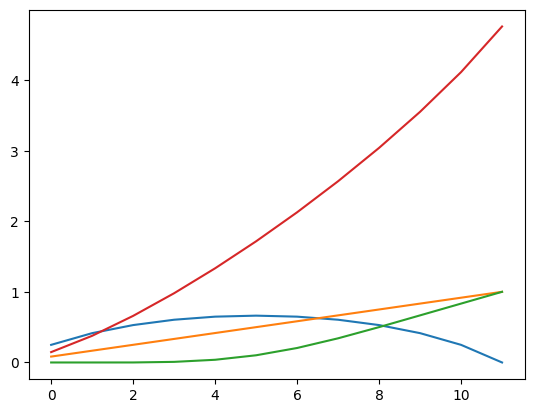

In [15]:
N = 12
points = 100
tfinal = 200

state = [fock(2,0)]*N
state[0] = fock(2,1)
initial_state = tensor(state)
H = spin_ham(N, 0.01)

tlist = np.linspace(0,tfinal,points)
result = mesolve(H, initial_state, tlist, [])
final_state = result.states[-1]

mean_entropy_list = [calc_mean_entropy(final_state, N, k) for k in range(1, N+1)]
mean_energy_list = [calc_mean_energy(final_state, N, k) for k in range(1, N+1)]
mean_ergotropy_list = [calc_mean_ergotropy(final_state, N, k) for k in range(1, N+1)]
mean_non_eq_free_energy_list = [calc_mean_non_eq_free_energy(final_state, N, k) for k in range(1, N+1)]


plt.plot(mean_entropy_list)
plt.plot(mean_energy_list)
plt.plot(mean_ergotropy_list)
plt.plot(mean_non_eq_free_energy_list)
plt.show()

In [16]:
k = 7
mean_entropy = calc_mean_entropy(final_state, N, k)
T = find_temp(mean_entropy, k)
print(entropy_vn(calc_gibbs(T, k)), mean_entropy)

4.075421762217536 0.6491899102055171


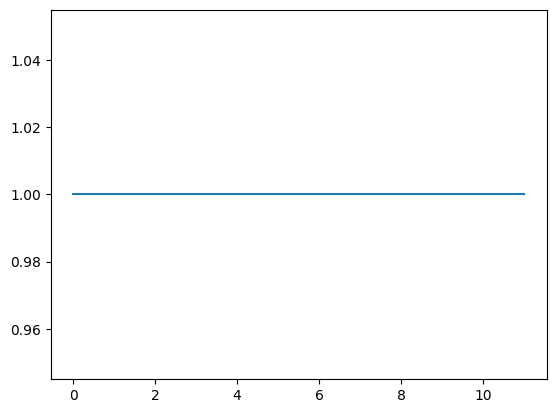

In [17]:
plt.plot([find_temp(calc_mean_entropy(final_state, N, k), k) for k in range(1,N+1)])
plt.show()

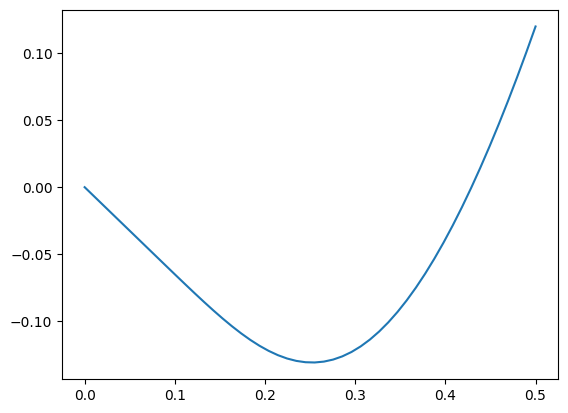

In [18]:
k = 7
T_list = np.linspace(10**(-5), 0.5)
mean_entropy = calc_mean_entropy(final_state, N, k)

plt.plot(T_list, [-g(T,mean_entropy, k) for T in T_list])
plt.show()

100%|██████████| 8/8 [00:17<00:00,  2.18s/it]


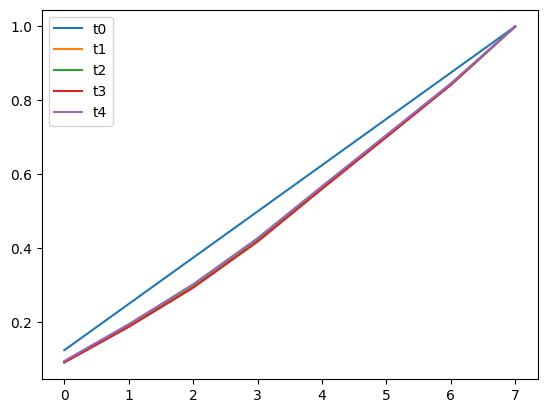

In [19]:
N = 8

state0 = random_product_state(N)
state1 = random_total_state(N)
state2 = random_total_state(N)
state3 = random_total_state(N)
state4 = random_total_state(N)


tot_erg0 = calc_mean_ergotropy(state0, N, N)
tot_erg1 = calc_mean_ergotropy(state1, N, N)
tot_erg2 = calc_mean_ergotropy(state2, N, N)
tot_erg3 = calc_mean_ergotropy(state3, N, N)
tot_erg4 = calc_mean_ergotropy(state4, N, N)

mean_erg0, mean_erg1, mean_erg2, mean_erg3, mean_erg4, mean_erg_rand = [], [], [], [], [], []
for k in tqdm(range(1,N+1)):
    mean_erg0.append(calc_mean_ergotropy(state0, N, k)/tot_erg0)
    mean_erg1.append(calc_mean_ergotropy(state1, N, k)/tot_erg1)
    mean_erg2.append(calc_mean_ergotropy(state2, N, k)/tot_erg2)
    mean_erg3.append(calc_mean_ergotropy(state3, N, k)/tot_erg3)
    mean_erg4.append(calc_mean_ergotropy(state4, N, k)/tot_erg4)
    
plt.plot(mean_erg0, label="t0")
plt.plot(mean_erg1, label="t1")
plt.plot(mean_erg2, label="t2")
plt.plot(mean_erg3, label="t3")
plt.plot(mean_erg4, label="t4")
plt.legend()
plt.show()

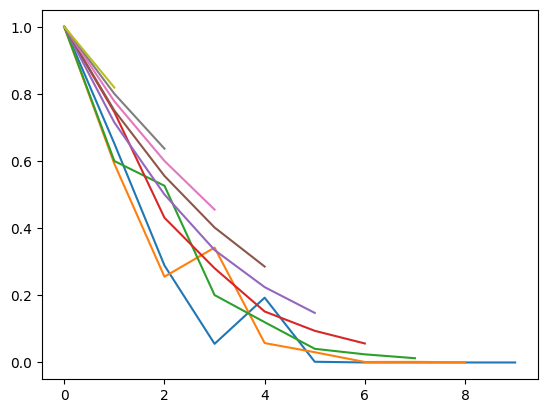

In [20]:
points = 100
tfinal = 200
Nmax = 12


for k in range(2, Nmax):
    mean_erg = []
    for N in range(k, Nmax):
        state = [fock(2,0)]*N
        state[0] = fock(2,1)
        initial_state = tensor(state)
        H = spin_ham(N, 0.01)

        tlist = np.linspace(0,tfinal,points)
        result = mesolve(H, initial_state, tlist, [])
        final_state = result.states[-1]
        rand_state = random_total_state(N)
        mean_erg.append(calc_mean_ergotropy(final_state, N, k))
    plt.plot(mean_erg)
plt.show()

100%|██████████| 10/10 [03:02<00:00, 18.26s/it]


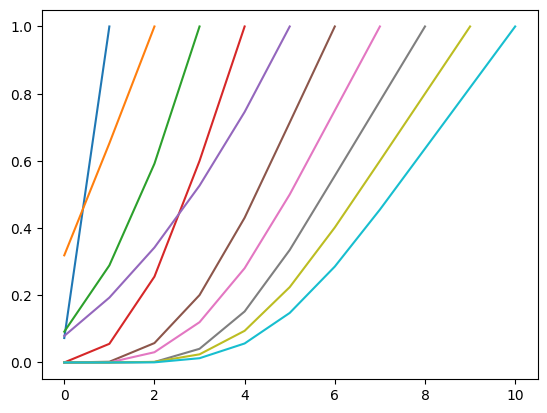

In [21]:
Nmax = 12

for N in tqdm(range(2, Nmax)):
    state = [fock(2,0)]*N
    state[0] = fock(2,1)
    initial_state = tensor(state)
    H = spin_ham(N, 0.01)

    tlist = np.linspace(0,tfinal,points)
    result = mesolve(H, initial_state, tlist, [])
    final_state = result.states[-1]
    rand_state = random_total_state(N)
    tot_erg = calc_mean_ergotropy(final_state, N, N)
    
    mean_erg = []
    for k in range(1,N+1):
        mean_erg.append(calc_mean_ergotropy(final_state, N, k)/tot_erg)
        
    plt.plot(mean_erg)
plt.show()

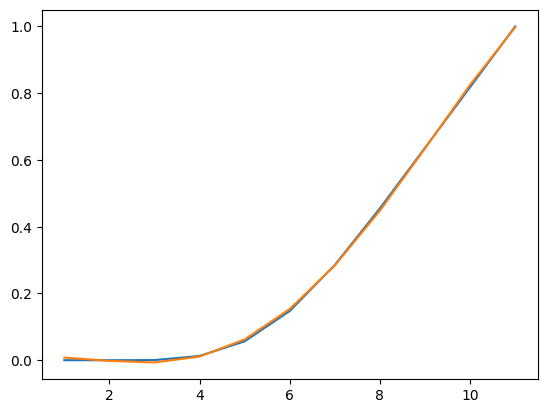

array([ 0.02614409, -0.02317223,  0.00529303, -0.00024119])

In [22]:
from scipy.optimize import curve_fit

def function(x, a, b, c, d):
    #return a * np.exp(b * x) 
    return a*x+b*x**2+c*x**3+d*x**4

x_data = [k for k in range(1,N+1)]
popt, pcov = curve_fit(function, x_data, mean_erg, p0=(1, 1, 1, 1))
fit =[function(x, popt[0], popt[1], popt[2], popt[3]) for x in x_data]

plt.plot(x_data, mean_erg)
plt.plot(x_data, fit)
plt.show()
popt

In [23]:
k=30
for i in range(N):
    avg = 0
    for t in range(k):
        avg += (result.states[99-t].ptrace(i)).diag()[0]
    print(avg/k)

0.8790767915869576
0.9505498802669031
0.7945184245603436
0.8626761852491575
0.9597274183532225
0.9925362594315527
0.9925362594315528
0.959727418353222
0.8626761852491567
0.7945184245603445
0.9505498802669039


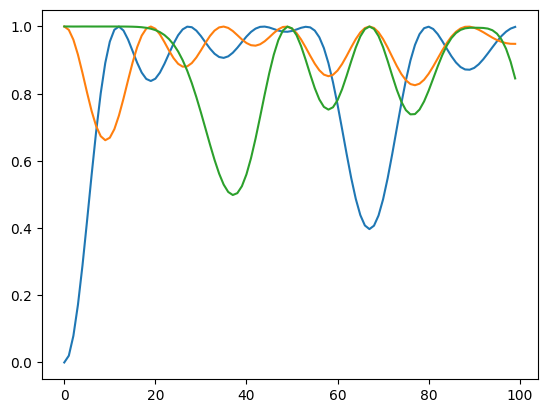

In [24]:
N = 12
points = 100
tfinal = 1000

state = [fock(2,0)]*N
state[0] = fock(2,1)
initial_state = tensor(state)
H = spin_ham(N, 0.01)

tlist = np.linspace(0,tfinal,points)
result = mesolve(H, initial_state, tlist, [])

pop0 = [(result.states[t].ptrace(0)).diag()[0] for t in range(100)]
pop1 = [(result.states[t].ptrace(1)).diag()[0] for t in range(100)]
pop2 = [(result.states[t].ptrace(6)).diag()[0] for t in range(100)]
plt.plot(pop0)
plt.plot(pop1)
plt.plot(pop2)
plt.show()

In [25]:
plt.hist(dist_ergotropy(state4, N, N-1), 50)
plt.show()

IndexError: Invalid selection index in ptrace.

In [ ]:
ham_energies(2)

In [30]:
from qutip import Qobj

# Define the matrix with components [1, 1, -1, 1]
u = (1/np.sqrt(2))*Qobj([[1, 1], [-1, 1]])


ghz=(tensor(basis(2,0), basis(2,0), basis(2,0)) + tensor(basis(2,1), basis(2,1), basis(2,1)) ).unit()
V=tensor(u,u,u)
V*ghz

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.5]
 [0. ]
 [0. ]
 [0.5]
 [0. ]
 [0.5]
 [0.5]
 [0. ]]

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]

In [33]:
Qobj([[2,1],[0,2],[3,4]])

Quantum object: dims = [[3], [2]], shape = (3, 2), type = oper, isherm = False
Qobj data =
[[2. 1.]
 [0. 2.]
 [3. 4.]]